In [58]:
import glob
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, fft
from scipy.interpolate import interp1d

import heartpy as hp

pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', 1000)
%matplotlib inline

NOTES:

Started test at 6:31 and lasted ~13 minutes

- Shake at start of glasses data on
- Sit still
- Shake 
- Push-ups
- Shake
- Sit still
- Shake
- Sit and talk/work as normal
- Shake
- Stand
- Shake at glasses off (just prior ~750ms from shake start to glasses off)
- Zephyr off


Get Zephyr Data -- timestamps are in seconds.  convert them to ms

In [5]:
files = sorted(glob.glob('zep_wearable_hr_data/history/log*'))

df = pd.DataFrame()
for file in files:
    df_file = pd.read_csv(file)
    df = pd.concat([df, df_file])

In [6]:
df.head()

,corrected_timestamp,samplerate,samples,sequence_number,timestamp,type
0,1621290045.246,250.000,"[-15, -15, -15, -15, -15, -15, -15, -15, -15, ...",33.000,1262334652.085,ecg
1,1621290045.463,50.000,"[[-0.9156626506024096, -0.963855421686747, -0....",164.000,1262334652.113,acceleration
2,1621290045.409,250.000,"[-21, -22, -22, -22, -22, -22, -22, -22, -22, ...",34.000,1262334652.337,ecg
3,1621290044.841,18.000,"[2, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 5, 5, 4, 3, ...",8.000,1262334651.845,breathing
4,1621290045.631,250.000,"[-21, -21, -21, -21, -21, -21, -21, -21, -21, ...",35.000,1262334652.589,ecg


In [7]:
def timestamp_and_ind_fn(init_corrected_timestamp, init_timestamp, samplerate):    
    def function(timestamp, ind):
        return int(1000*(timestamp - init_timestamp + init_corrected_timestamp) + ind*(1000/samplerate))
    return function

In [8]:
df_temp = df[df.type == 'ecg']

df_ecg = pd.DataFrame()

timestamp_fnc = timestamp_and_ind_fn(df_temp['corrected_timestamp'].iloc[0], 
                                     df_temp['timestamp'].iloc[0],
                                     df_temp['samplerate'].iloc[0])

for ind, row in df_temp.iterrows():
    values = ast.literal_eval(row['samples'])
    timestamps = [timestamp_fnc(row['timestamp'], i) for i in range(0, len(values))]
    df_ecg = pd.concat([df_ecg, pd.DataFrame({'value':values, 't':timestamps})])

In [9]:
df_temp = df[df.type == 'breathing']

df_breath = pd.DataFrame()

timestamp_fnc = timestamp_and_ind_fn(df_temp['corrected_timestamp'].iloc[0], 
                                     df_temp['timestamp'].iloc[0],
                                     df_temp['samplerate'].iloc[0])

for ind, row in df_temp.iterrows():
    values = ast.literal_eval(row['samples'])
    timestamps = [timestamp_fnc(row['timestamp'], i) for i in range(0, len(values))]
    df_breath = pd.concat([df_breath, pd.DataFrame({'value':values, 't':timestamps})])

In [10]:
df_temp.head()

,corrected_timestamp,samplerate,samples,sequence_number,timestamp,type
3,1621290044.841,18.000,"[2, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 5, 5, 4, 3, ...",8.000,1262334651.845,breathing
17,1621290045.850,18.000,"[2, 2, 1, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 1, 1, ...",9.000,1262334652.853,breathing
29,1621290046.858,18.000,"[0, -1, 0, 0, 1, 2, 3, 3, 3, 3, 3, 2, 1, 1, 0,...",10.000,1262334653.861,breathing
42,1621290047.865,18.000,"[-5, -7, -8, -9, -10, -10, -11, -11, -11, -12,...",11.000,1262334654.866,breathing
2,1621290048.875,18.000,"[-23, -23, -22, -22, -20, -19, -18, -17, -17, ...",12.000,1262334655.877,breathing


In [11]:
df_temp = df[df.type == 'acceleration']

df_accel = pd.DataFrame()

timestamp_fnc = timestamp_and_ind_fn(df_temp['corrected_timestamp'].iloc[0], 
                                     df_temp['timestamp'].iloc[0],
                                     df_temp['samplerate'].iloc[0])

for ind, row in df_temp.iterrows():
    values = ast.literal_eval(row['samples'])
    timestamps = [timestamp_fnc(row['timestamp'], i) for i in range(0, len(values[0]))]
    df_accel = pd.concat([df_accel, pd.DataFrame({'x':values[0], 'y':values[1], 'z':values[2], 't':timestamps})])

We now have from the zephyr

- `df_ecg` - a 250 Hz ECG df with time 't' (in ms) and values 'value'
- `df_breath` - an 8 Hz breath df with time 't' (in ms)  and values 'value'
- `df_accel` - a 50 Hz accelerometer df with time 't' (in ms) and 'x', 'y', 'z'

And from the glasses (1=accel, 2=gyro):

In [12]:
df_file = pd.read_csv('inertialMeas_test1.csv')
#df_file.head()
df_file.columns

Index(['_id', 'desc', 'packetIdx', 'payload.0.accuracy', 'payload.0.imu_tick',
       'payload.0.tick', 'payload.0.x', 'payload.0.y', 'payload.0.z',
       'payload.1.accuracy', 'payload.1.imu_tick', 'payload.1.tick',
       'payload.1.x', 'payload.1.y', 'payload.1.z', 'payload.10.accuracy',
       'payload.10.imu_tick', 'payload.10.tick', 'payload.10.x',
       'payload.10.y', 'payload.10.z', 'payload.11.accuracy',
       'payload.11.imu_tick', 'payload.11.tick', 'payload.11.x',
       'payload.11.y', 'payload.11.z', 'payload.12.accuracy',
       'payload.12.imu_tick', 'payload.12.tick', 'payload.12.x',
       'payload.12.y', 'payload.12.z', 'payload.13.accuracy',
       'payload.13.imu_tick', 'payload.13.tick', 'payload.13.x',
       'payload.13.y', 'payload.13.z', 'payload.2.accuracy',
       'payload.2.imu_tick', 'payload.2.tick', 'payload.2.x', 'payload.2.y',
       'payload.2.z', 'payload.3.accuracy', 'payload.3.imu_tick',
       'payload.3.tick', 'payload.3.x', 'payload.3.y', 'p

In [13]:
df_temp = df_file[df_file.desc == 1]

def timestamp_fn_glasses(init_server_timestamp, init_tick):    
    def function(tick):
        return int((tick - init_tick)/2 + init_server_timestamp)
    return function

df_glass_acc = pd.DataFrame()

timestamp_fnc = timestamp_fn_glasses(df_temp['serverTimestamp'].iloc[0], 
                                     df_temp['payload.0.tick'].iloc[0])

for ind, row in df_temp.iterrows():
    x,y,z,acc = [],[],[],[]
    times = []
    for i in range(10):
        pkt_name = 'payload.' + str(i) + '.'
        times.append(timestamp_fnc(row[pkt_name + 'tick']))
        x.append(row[pkt_name + 'x'])
        y.append(row[pkt_name + 'y'])
        z.append(row[pkt_name + 'z'])
        acc.append(row[pkt_name + 'accuracy'])
    x = [v if v <= 65535/2 else v - 65535 for v in x]  
    y = [v if v <= 65535/2 else v - 65535 for v in y]  
    z = [v if v <= 65535/2 else v - 65535 for v in z]  
        
    df_glass_acc = pd.concat([df_glass_acc, pd.DataFrame({'x':x, 'y':y, 'z':z, 't':times, 'acc':acc})])

In [14]:
df_temp = df_file[df_file.desc == 2]

def timestamp_fn_glasses(init_server_timestamp, init_tick):    
    def function(tick):
        return int((tick - init_tick)/2 + init_server_timestamp)
    return function

df_glass_gyro = pd.DataFrame()

timestamp_fnc = timestamp_fn_glasses(df_temp['serverTimestamp'].iloc[0], 
                                     df_temp['payload.0.tick'].iloc[0])

for ind, row in df_temp.iterrows():
    x,y,z,acc = [],[],[],[]
    times = []
    for i in range(10):
        pkt_name = 'payload.' + str(i) + '.'
        times.append(timestamp_fnc(row[pkt_name + 'tick']))
        x.append(row[pkt_name + 'x'])
        y.append(row[pkt_name + 'y'])
        z.append(row[pkt_name + 'z'])
        acc.append(row[pkt_name + 'accuracy'])
    x = [v if v <= 65535/2 else v - 65535 for v in x]  
    y = [v if v <= 65535/2 else v - 65535 for v in y]  
    z = [v if v <= 65535/2 else v - 65535 for v in z]  
    
    df_glass_gyro = pd.concat([df_glass_gyro, pd.DataFrame({'x':x, 'y':y, 'z':z, 't':times, 'acc':acc})])

Now we have `df_glass_acc` and `df_glass_gyro` from the glasses, each with a timestamp 't' (in ms) and data in 'x','y','z' and an estimated accuracy 'acc'

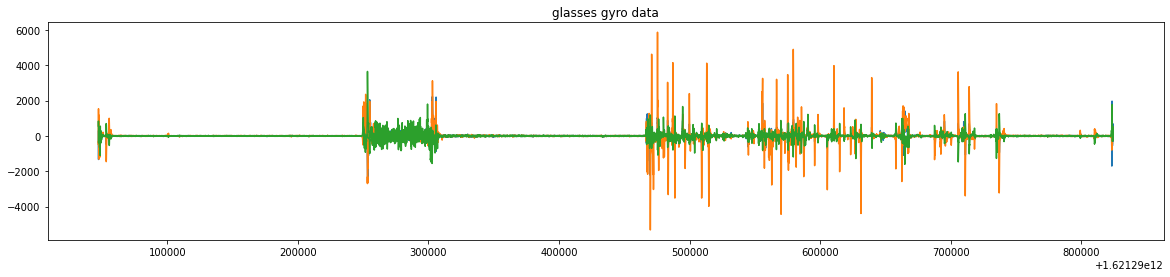

In [15]:
fig = plt.figure(figsize=(20,4))
plt.plot(df_glass_gyro.t, df_glass_gyro.x, label='x')
plt.plot(df_glass_gyro.t, df_glass_gyro.y, label='y')
plt.plot(df_glass_gyro.t, df_glass_gyro.z, label='z')
plt.title('glasses gyro data')
plt.show()

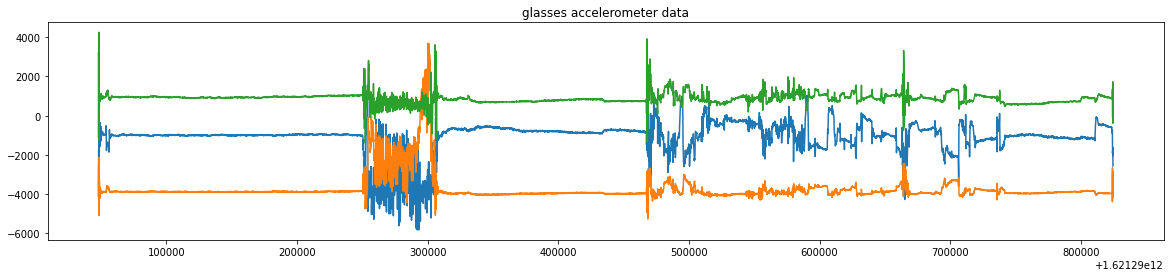

In [16]:
fig = plt.figure(figsize=(20,4))
plt.plot(df_glass_acc.t, df_glass_acc.x, label='x')
plt.plot(df_glass_acc.t, df_glass_acc.y, label='y')
plt.plot(df_glass_acc.t, df_glass_acc.z, label='z')
plt.title('glasses accelerometer data')
plt.show()

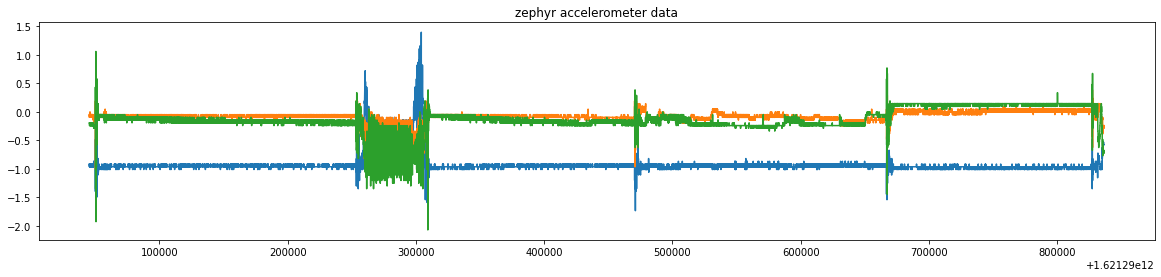

In [17]:
fig = plt.figure(figsize=(20,4))
plt.plot(df_accel.t, df_accel.x, label='x')
plt.plot(df_accel.t, df_accel.y, label='y')
plt.plot(df_accel.t, df_accel.z, label='z')
plt.title('zephyr accelerometer data')
plt.show()

## READY TO ANALYZE

Data is prepped and ready to analyze.

We have from the Zephyr

- `df_ecg` - a 250 Hz ECG df with time 't' (in ms) and values 'value'
- `df_breath` - an 8 Hz breath df with time 't' (in ms)  and values 'value'
- `df_accel` - a 50 Hz accelerometer df with time 't' (in ms) and 'x', 'y', 'z'

We have from the glasses

- `df_glass_acc` - accel with a timestamp 't' (in ms) and data in 'x','y','z' and an estimated accuracy 'acc' from the accelerometer
- `df_glass_gyro` - gyro data with a timestamp 't' (in ms) and data in 'x','y','z' and an estimated accuracy 'acc' from the accelerometer

From https://affect.media.mit.edu/pdfs/14.Hernandez.Li.Rehg.Picard-MobiHealth.pdf
    
Both 3-axis accelerometer and 3-axis gyroscope were retrieved at an average sampling rate of 50 Hz. In order to ensure a constant sampling rate, we performed cubic interpolation at a sampling rate of 256 Hz.

They
(1) HPF by **subtracting** a centered 3-sample time average.
(2) 4th-order Bandpass Butterworth at 10-13 Hz
(3) Take an L2 norm to go from 3 axes to a magnitude
(4) 2nd-order Bandpass Butterworth at 0.75-2.5Hz

This gives the 'Pulse Wave' that matches the 'Blood Volume Pulse'.  FFT to get peak Hz\*60 = bpm, FFT between 0 and 2.5Hz. 

For respiration:
(1) LPF with max frequency of 45Hz with moving average.
(2) 4th-order Bandpass Butterworth from 0.13-0.75Hz
(3) PCA to maximize variance (transform to dim of maximum variation)
(4) FFT and take peak amplitude

FFTs are 0-2.5Hz

Also: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4384813/

"To sense the BCG at the head in a portable and wearable manner, we use a MEMS tri-axial digital accelerometer. Because head BCG is in the range of 10mGp−p, a highly sensitive and low noise accelerometer is needed. We choose Bosch's BMA180 accelerometer for its 14-bit resolution and 0.69mGRMS of measured noise at 10Hz bandwidth with ±2G range."

BNO055 - 1mG quantization, error
BNO080 - 8G mode, likley to not be sensitive enough to do this.  reports in increments of 0.4mG.

In [18]:
glass_min = [(t-df_glass_gyro.t.iloc[0])/(1000*60) for t in df_glass_gyro.t]
glass_accel_min = [(t-df_glass_acc.t.iloc[0])/(1000*60) for t in df_glass_acc.t]
zep_min = [(t-df_ecg.t.iloc[0])/(1000*60) for t in df_ecg.t]
zep_accel_min = [(t-df_accel.t.iloc[0])/(1000*60) for t in df_accel.t]

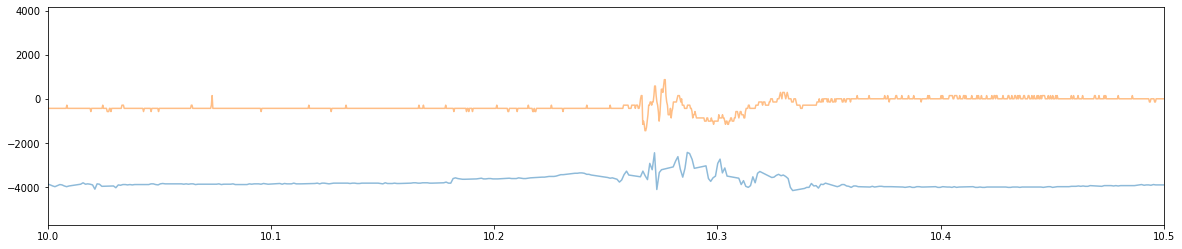

In [19]:
MIN_OFFSET = 0.09

fig = plt.figure(figsize=(20,4))
plt.plot(glass_accel_min, df_glass_acc.y, '-', alpha=0.5)
plt.plot([t-MIN_OFFSET for t in zep_accel_min], df_accel.y*3000, alpha=0.5)
plt.xlim(10,10.5)
plt.show()

#looks like timestamps are off by about 0.09 min, or 5.4 seconds

In [20]:
#STEP 1: interpolate to 256 Hz

timestart = df_glass_gyro['t'].iloc[0]
timeend   = df_glass_gyro['t'].iloc[-1]

newt = np.arange(timestart, timeend, 1000/256)
newt_min = [(t-newt[0])/(1000*60) for t in newt]

fx = interp1d(df_glass_gyro['t'], df_glass_gyro['x'], kind='cubic')
fy = interp1d(df_glass_gyro['t'], df_glass_gyro['y'], kind='cubic')
fz = interp1d(df_glass_gyro['t'], df_glass_gyro['z'], kind='cubic')

newx = fx(newt)
newy = fy(newt)
newz = fz(newt)

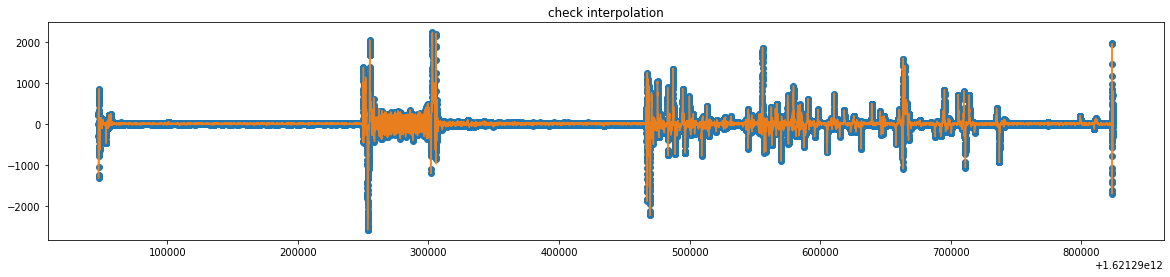

In [21]:
fig = plt.figure(figsize=(20,4))
plt.plot(df_glass_gyro['t'], df_glass_gyro['x'], 'o')
plt.plot(newt, newx, '-', alpha=0.9)
plt.title('check interpolation')
plt.show()

In [22]:
#STEP 2: subtract 3 sample average to LPF

def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'same') / w
    
newx = newx - moving_average(newx, 3)
newy = newy - moving_average(newy, 3)
newz = newz - moving_average(newz, 3)

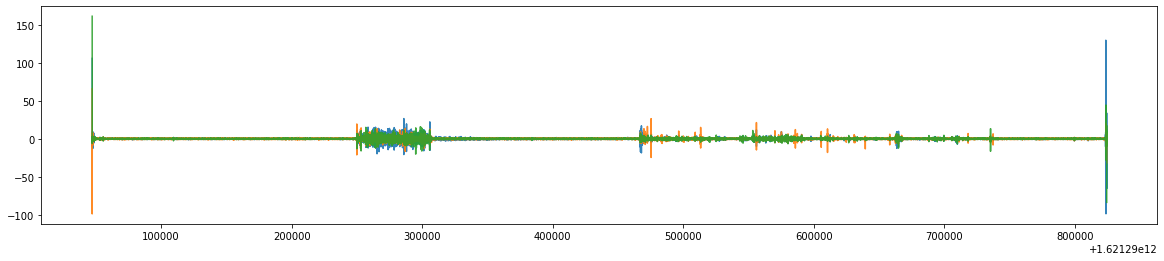

In [23]:
fig = plt.figure(figsize=(20,4))
plt.plot(newt, newx, '-', alpha=0.9)
plt.plot(newt, newy, '-', alpha=0.9)
plt.plot(newt, newz, '-', alpha=0.9)
plt.show()

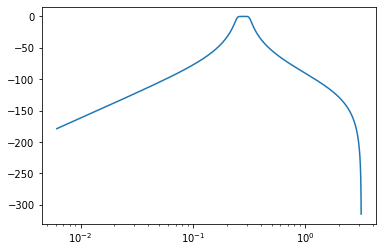

In [24]:
#STEP 3: 4th order BPF Butterworth 10-13 Hz

sos = signal.butter(4, [10, 13], 'bandpass', fs=256, output='sos')

w, h = signal.sosfreqz(sos)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.show()

newx = signal.sosfilt(sos, newx)
newy = signal.sosfilt(sos, newy)
newz = signal.sosfilt(sos, newz)

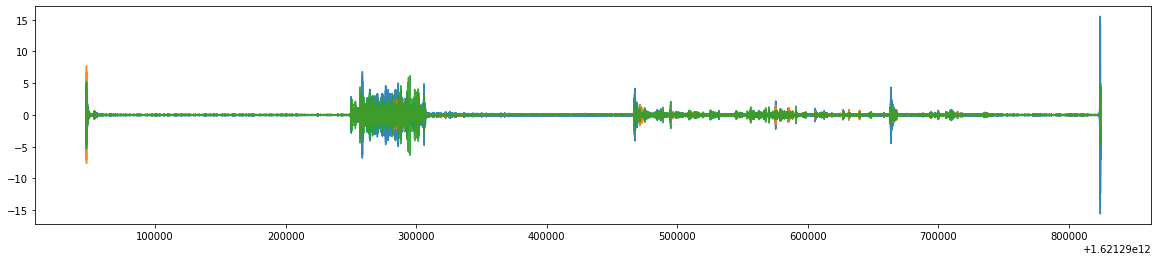

In [25]:
fig = plt.figure(figsize=(20,4))
plt.plot(newt, newx, '-', alpha=0.9)
plt.plot(newt, newy, '-', alpha=0.9)
plt.plot(newt, newz, '-', alpha=0.9)
plt.show()

In [26]:
#STEP 4: L2 Norm magnitude
l2_norm = [np.sqrt(x*x+y*y+z*z) for (x,y,z) in zip(newx, newy, newz)]

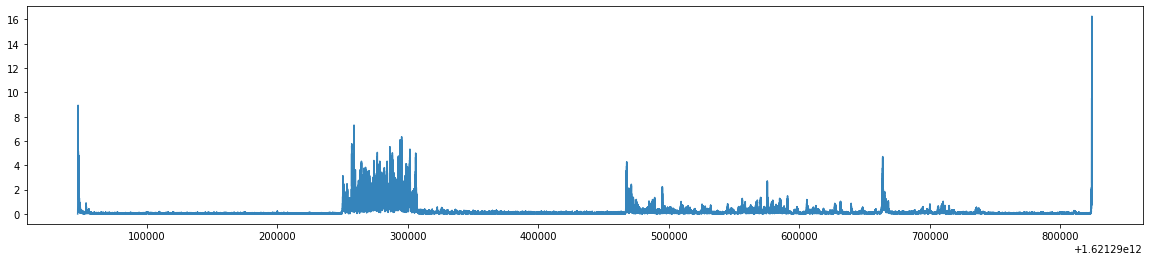

In [27]:
fig = plt.figure(figsize=(20,4))
plt.plot(newt, l2_norm, '-', alpha=0.9)
plt.show()

In [28]:
#STEP 5: 2nd order BPF Butterworth 0.75-2.5 Hz

sos = signal.butter(2, [0.75, 2.5], 'bandpass', fs=256, output='sos')

final = signal.sosfilt(sos, l2_norm)

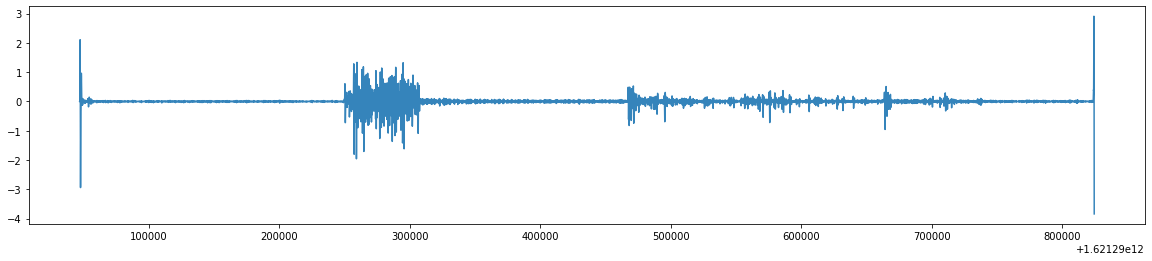

In [29]:
fig = plt.figure(figsize=(20,4))
plt.plot(newt, final, '-', alpha=0.9)
plt.show()

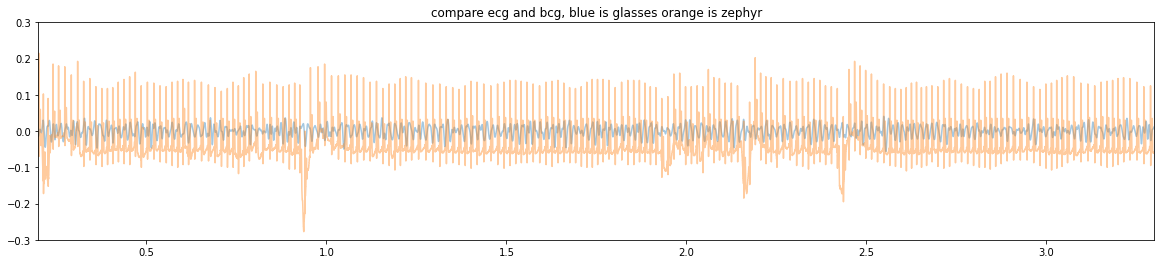

In [30]:
fig = plt.figure(figsize=(20,4))
plt.plot(newt_min, final, '-', alpha=0.4)
plt.plot(zep_min, df_ecg.value/400, alpha=0.4)
plt.xlim(.2,3.3)
plt.ylim(-.3,.3)
plt.title('compare ecg and bcg, blue is glasses orange is zephyr')
plt.show()

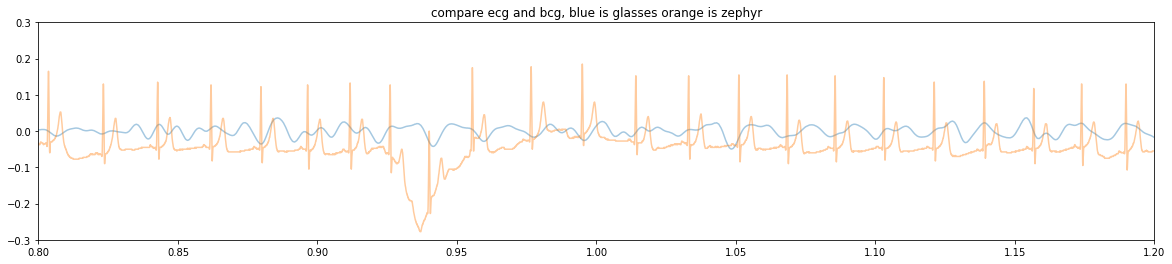

In [31]:
fig = plt.figure(figsize=(20,4))
plt.plot(newt_min, final, '-', alpha=0.4)
plt.plot(zep_min, df_ecg.value/400, alpha=0.4)
plt.xlim(.8,1.2)
plt.ylim(-.3,.3)
plt.title('compare ecg and bcg, blue is glasses orange is zephyr')
plt.show()

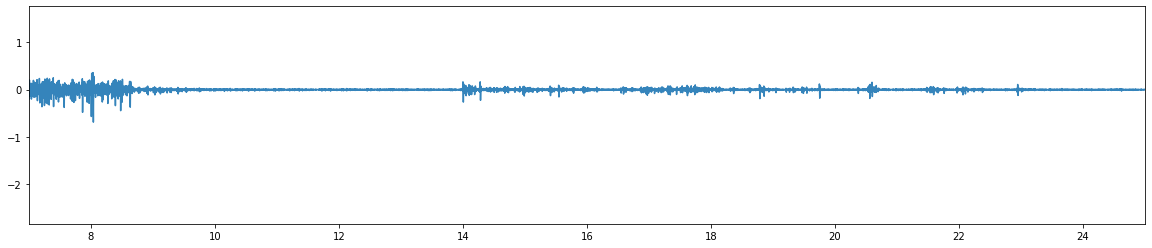

In [152]:
fig = plt.figure(figsize=(20,4))
plt.plot(newt_min, final, '-', alpha=0.9)
plt.xlim(7,25)
plt.show()

In [36]:
#START TIME: 0.06 min - 6.75 min (still, resting)


# Analyze ECG Data

/usr/local/lib/python3.9/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


bpm: 203.556387
ibi: 294.758621
sdnn: 162.086749
sdsd: 117.433669
rmssd: 251.146703
pnn20: 1.000000
pnn50: 0.875000
hr_mad: 132.000000
sd1: 176.258648
sd2: 133.093117
s: 73698.034251
sd1/sd2: 1.324326
breathingrate: 0.350959


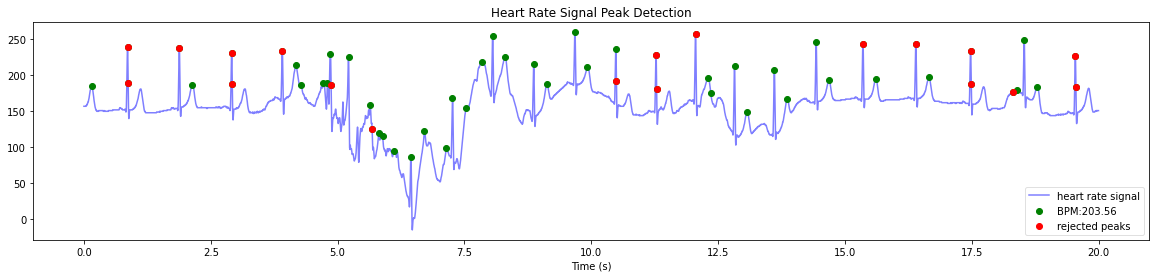

In [46]:
#run analysis
wd, m = hp.process(df_ecg.value.tolist()[0:250*20], 250)

#visualise in plot of custom size
hp.plotter(wd, m, figsize=(20,4))

#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

looks pretty bad

/usr/local/lib/python3.9/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


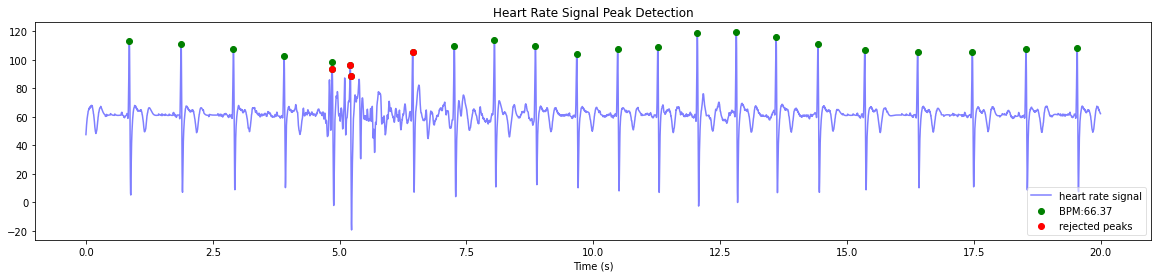

In [48]:
sos = signal.butter(2, 5, 'highpass', fs=250, output='sos')

ecg_hp = signal.sosfilt(sos, df_ecg.value.tolist())

wd, m = hp.process(ecg_hp[0:250*20], 250)

#visualise in plot of custom size
hp.plotter(wd, m, figsize=(20,4))


looks better

# Pull out BPM and Compare

## From Paper

They show a plot of an FFT between 0-2.5 Hz, and select the peak.  That times 60 = our BPM.

Example from paper shows resolution of 0.01 Hz in FFT, however they say they used "20 seconds with a 75% overlap".  A 5,120 point FFT with resolution 256/5120 = 0.05 Hz.

We'll use our 256 Hz 'blood pulse' `final` signal, take FFTs of 20 seconds with 75% overlap.  Times are in `newt_min`.

## to compare

For 250 Hz HP `ecg_hp` signal list (with corresponding `zep_min` timestamps), we can just take a window and apply `hp.process` as above.  Since our sample rates are not quite the same, we need to base our indexing on the `newt_min` compared to `zep_min`.


In [68]:
#fft size
N = 256 * 20
T = 1 / 256.
step = int(N / 4)

#get fft frequencies, *60 to get BPM.
xf = fft.fftfreq(N, T)[:N//2]
xf *= 60

i=0
zep_bpm, gls_bpm = [], []

while i+n < len(newt_min):

    #take an fft of those from final, get f at max, append BPM associated with it
    y = np.abs(fft.fft(final[i:i+n])[0:N//2])
    y_ind = np.where(y == np.max(y))[0][0]
    gls_bpm.append(xf[y_ind])
    
    ### DEBUG DERIVED BPM 
    #plt.plot(xf[0:50], y[0:50])
    #plt.show()
    #print(y_ind)
    #print(gls_bpm)
    
    ###
    
    #times we used
    min_time = newt_min[i]
    max_time = newt_min[i+n]
    
    #get indices in range in zep_min
    indices = np.where(np.logical_and(zep_min>=min_time, zep_min<=max_time))
    
    #calc BPM and append
    _, m = hp.process(ecg_hp[indices[0][0]:indices[0][-1]], 250)
    zep_bpm.append(m['bpm'])
    
    i += step

In [69]:
print(zep_bpm)

[66.3716814159292, 66.61991584852734, 64.37768240343348, 60.27918781725889, 61.29032258064516, 59.6234309623431, 59.25155925155925, 58.42558425584255, 58.847821598182946, 57.50798722044729, 57.337014228073905, 58.05203182111374, 56.47354110018825, 56.9577842305115, 56.426332288401255, 56.50899958141481, 58.340535868625764, 59.73451327433628, 61.19819626368907, 61.893955023726015, 62.12466349140609, 61.893955023726015, 62.13753106876553, 62.5, 61.47540983606557, 61.11945099721209, 62.03473945409429, 61.05398457583548, 64.02439024390245, 64.26735218508998, 63.54585892819318, 63.9386189258312, 60.012634238787115, 60.9234715690466, 58.41627001298139, 59.08096280087528, 58.30274238825308, 58.42891149101926, 59.35370411079358, 65.27714154832799, 79.59905660377358, 94.6372239747634, 100.72522159548753, 110.26709139916687, 118.34319526627219, 121.65815560228297, 123.8441215323646, 126.47554806070826, 132.02933985330074, 152.5873507297656, 145.5026455026455, 128.60483242400622, 106.497418244406

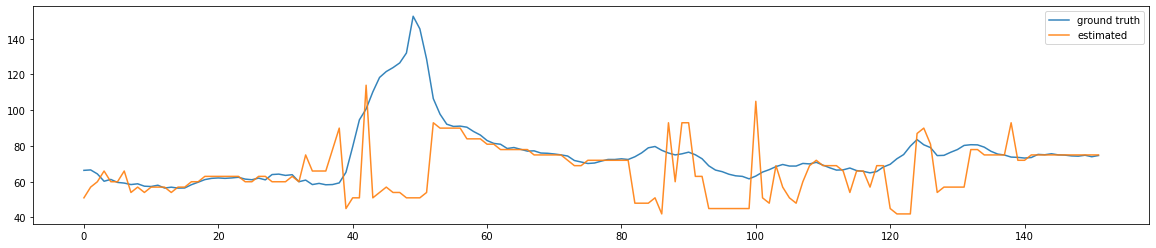

In [72]:
fig = plt.figure(figsize=(20,4))
plt.plot(range(len(zep_bpm)), zep_bpm, '-', alpha=0.9, label='ground truth')
plt.plot(range(len(zep_bpm)), gls_bpm, '-', alpha=0.9, label='estimated')
plt.legend()
plt.show()